# Algorithms

Study and comparison of different techniques and clustering algorithms.

In [66]:
# Libraries
import pandas as pd
import numpy as np
import json

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize


# for KNN:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors



# for K approximations:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Encoding
Some data processing has to be done since there's noninal attributes that have to be encoded for the algorithms to work. One-hot encoding is tipically used for nominal attributes, but the computational power required to use it across tens of thousands of films is too big. Thus, we've opted for a label encoding, which would otherwise be more suitable for ordinal string attributes.

In [67]:
# We're mainly working with these smaller dataset.
df_movies = pd.read_json("Data/datasets/final/movies_reduced_25.json", orient="records")
df_ratings = pd.read_json("Data/datasets/final/ratings_reduced_25.json", orient="records")

In [68]:
# dict holding the column name and its respective encoder.
encoder_dict = {}

### Title

In [69]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
df_movies['title'] = le.fit_transform(df_movies['title'])

# Add encoder to dict
encoder_dict['title'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,mean,std
0,166558,4193,"[action, horror]",2016,movie,Anna Foerster,Cory Goodman,action,horror,None,3.412371,1.070461
1,119068,2423,"[comedy, drama]",2014,movie,Jason Reitman,Chad Kultgen,comedy,drama,None,3.822581,0.822074


### Genres

As we can see bellow, there are 20 different genres. (With this smaller number we can try to apply the one-hot encoding method.) Label encoding will be used as 1-hot adds too many dimensions and computational complexity.

In [70]:
df_movies['genres'].explode().unique()

array(['action', 'horror', 'comedy', 'drama', 'romance', 'adventure',
       'documentary', 'crime', 'musical', 'children', 'western', 'war',
       'fantasy', 'animation', 'sci-fi', 'mystery', 'thriller',
       '(no genres listed)', 'imax', 'film-noir'], dtype=object)

#### One-hot encoding

In [303]:
# PREVIOUS!!

# # One-hot encoder.
# enc = OneHotEncoder(handle_unknown='ignore')

# # Fitting requires a 2D array. Reshape converts our 1D array into 2D.
# arr = np.array(df_movies['genres'].explode().unique()).reshape(-1,1)

# enc.fit(arr)

# # Add encoder to dict
# encoder_dict['genres'] = enc

In [304]:
# PREVIOUS!!

# # Example of transformation and inverse transformation.
# tr = enc.transform([['action'], ['adventure']]).toarray()
# tr

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [305]:
# PREVIOUS!!

# enc.inverse_transform(tr)

array([['action'],
       ['adventure']], dtype=object)

In [306]:
# PREVIOUS!!

# # Applying one-hot encoding to each row in genres.

# # 1st, define function to apply:
# def one_hot_encode(x, enc):
#     """
#     Encodes a 1D array using one-hot encoding.

#     Some 
#     Parameters
#     ---------- 
#     x : 1D list of parameters to encode.
#     enc : already defined one-hot encoder.
        
#     Returns
#     -------
#     1D array containing the encoding.
#     """
#     arr = enc.transform(np.array(x).reshape(-1,1)).toarray()
    
#     # sum: [[0,1,0,0], [1,0,0,0]] -> [1,1,0,0].
#     return sum(arr)

# # Now that we're at it, a decoding function should be defined as well.
# def one_hot_decode(x, enc):
#     """
#     Decodes a 1D vector using one-hot encoding.

#     Parameters
#     ---------- 
#     x : 2D vectori with previously encoded parameters.
#     enc : already defined one-hot encoder.

#     Returns
#     -------
#     1D array containing the decoded parameters.
#     """
#     # TODO: transformation to 2D array and posterior decoding.
#     return np.array(enc.inverse_transform(x)).flatten()

In [307]:
# PREVIOUS!!

df_movies['genres'] = df_movies['genres'].apply(one_hot_encode, enc=enc)

In [308]:
# PREVIOUS!!

df_movies['genres'].head(200)[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

#### Label encoding

In [71]:
def label_encoder(x, encoder):
    return encoder.transform([x])[0]

# TODO: check this works.
def label_decoder(x, encoder):
    return encoder.inverse_transform(x)

In [72]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
le.fit(
    np.append(df_movies['genres'].explode().unique(), None)
    )
df_movies['genre_0'] = df_movies['genre_0'].apply(label_encoder, encoder=le)
df_movies['genre_1'] = df_movies['genre_1'].apply(label_encoder, encoder=le)
df_movies['genre_2'] = df_movies['genre_2'].apply(label_encoder, encoder=le)


# Add encoder to dict
encoder_dict['genres'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,mean,std
0,166558,4193,"[action, horror]",2016,movie,Anna Foerster,Cory Goodman,1,11,20,3.412371,1.070461
1,119068,2423,"[comedy, drama]",2014,movie,Jason Reitman,Chad Kultgen,5,8,20,3.822581,0.822074


### Movie type

Only 4 movie types exist, so one-hot encoding will be used.

In [73]:
df_movies['titleType'].explode().unique()

array(['movie', 'short', 'tvMovie', 'tvShort'], dtype=object)

#### One-hot encoding

In similar fasion to 'genres', one-hot encoding is not used in the end.

In [310]:
# # One-hot encoder.
# enc = OneHotEncoder(handle_unknown='ignore')

# # Fitting requires a 2D array. Reshape converts our 1D array into 2D.
# arr = np.array(df_movies['titleType'].explode().unique()).reshape(-1,1)

# enc.fit(arr)

# # Add encoder to dict
# encoder_dict['titleType'] = enc

In [311]:
# df_movies['titleType'] = df_movies['titleType'].apply(one_hot_encode, enc=enc)

#### Label encoding

In [74]:
# Label encoding. 'le' variable is used for later decoding.
le = LabelEncoder()
df_movies['titleType'] = le.fit_transform(df_movies['titleType'])

# Add encoder to dict
encoder_dict['titleType'] = le

df_movies.head(2)


df_movies['titleType'] = le.fit_transform(df_movies['titleType'])


### Directors

There are ~7k directors, so Label encoding seems to be more appropiate.

In [75]:
len(df_movies['director'].explode().unique())

3478

In [76]:
le = LabelEncoder()
df_movies['director'] = le.fit_transform(df_movies['director'])

# Add encoder to dict
encoder_dict['director'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,mean,std
0,166558,4193,"[action, horror]",2016,0,200,Cory Goodman,1,11,20,3.412371,1.070461
1,119068,2423,"[comedy, drama]",2014,0,1468,Chad Kultgen,5,8,20,3.822581,0.822074


### Writers

There are ~8k directors, so Label encoding will be used.

In [77]:
len(df_movies['writer'].explode().unique())

3922

In [78]:
le = LabelEncoder()
df_movies['writer'] = le.fit_transform(df_movies['writer'])

# Add encoder to dict
encoder_dict['writer'] = le

df_movies.head(2)

,movieId,title,genres,year,titleType,director,writer,genre_0,genre_1,genre_2,mean,std
0,166558,4193,"[action, horror]",2016,0,200,669,1,11,20,3.412371,1.070461
1,119068,2423,"[comedy, drama]",2014,0,1468,531,5,8,20,3.822581,0.822074


In [79]:
# Checking that all encoders have been added to the dict
encoder_dict

{'title': LabelEncoder(),
 'genres': LabelEncoder(),
 'titleType': LabelEncoder(),
 'director': LabelEncoder(),
 'writer': LabelEncoder()}

In [80]:
# Drop movieId and genres column
df_movies.drop(['movieId', 'genres'], axis=1, inplace=True)

### Normalization

In [81]:
df_movies.isnull().sum()

title        0
year         0
titleType    0
director     0
writer       0
genre_0      0
genre_1      0
genre_2      0
mean         0
std          0
dtype: int64

In [82]:
# Data normalization using L2 norm.
x = normalize(df_movies, norm='l2')


In [84]:
x[0]

array([8.91248529e-01, 4.28513483e-01, 0.00000000e+00, 4.25112582e-02,
       1.42200159e-01, 2.12556291e-04, 2.33811920e-03, 4.25112582e-03,
       7.25320953e-04, 2.27533247e-04])

Once all the data has been properly encoded, different algorithms will be tried.

## KNN

### Rudimentary KNN

In [86]:
knn_movies_basic = NearestNeighbors(
    algorithm = 'ball_tree',        # generally faster.
    metric='minkowski',             # default: minkowski.
    n_neighbors=15,                 # Random number for this basic model.
    n_jobs=-1                       # Uses all processors.
)

In [87]:
km_movies_basic = KMeans(n_clusters=15, random_state=0)

In [88]:
km_movies_basic.fit(x)

KMeans(n_clusters=15, random_state=0)

### KNN with K approximation

Different methods that the literature suggest will be used.


#### Elbow Method 

A more rudimentary method, [explanation]...

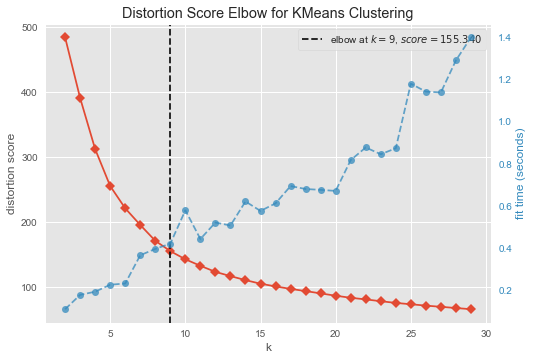

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [98]:
model = KMeans(
    n_init = 20,
    algorithm = 'elkan'
)
visualizer = KElbowVisualizer(
    model,
    k=(2,30),                       # k is range of number of clusters.
    timings= True
    )

visualizer.fit(x)                   # Fit data to visualizer
visualizer.show()                   # Finalize and render the figure

#### Silhouette score method

Calculates the mean Silhouette Coefficient of all samples.

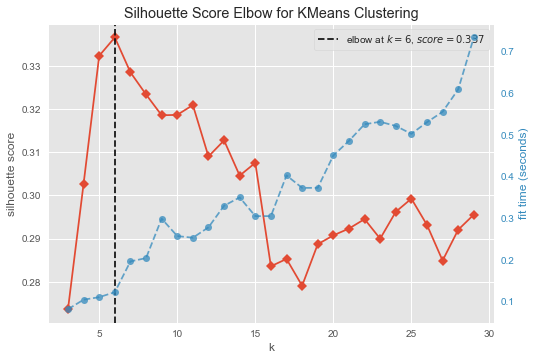

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [103]:
model = KMeans()

visualizer = KElbowVisualizer(
    model,
    k=(3,30),                   # k is range of number of clusters.
    metric = 'silhouette',      # 2nd method to approximate K.
    timings=True
    )

visualizer.fit(x)               # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure

#### Calinski Harabasz method

Computes the ratio of dispersion between and within clusters

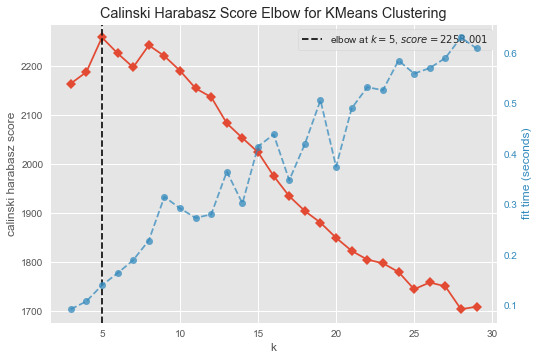

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [104]:
model = KMeans()

visualizer = KElbowVisualizer(
    model,
    k=(3,30),                           # k is range of number of clusters.
    metric = 'calinski_harabasz',       # 3rd method to approximate K.
    timings=True
    )

visualizer.fit(x)               # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure


#### DB Index

[explanation]

In [ ]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(df_ratings)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(df_ratings, model)

    return score
    
scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(df_ratings, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');